# TP1 - Graphs

In [1]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from more_itertools import powerset
import time

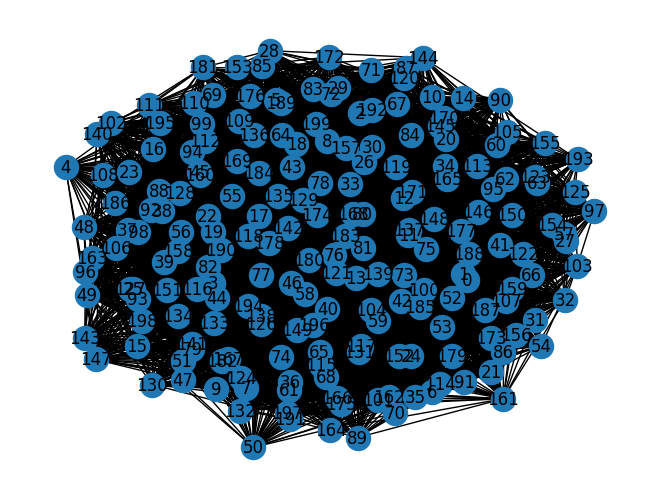

In [24]:
# use networkx to generate a random graph erdos_renyi_graph
G = nx.erdos_renyi_graph(200, 0.3, seed=1)
# use networkx to draw the graph
nx.draw(G, with_labels=True)
# show the graph
plt.show()

# Naive

```python
fonction recherche_clique(graphe G):
    n = nombre de sommets de G
    taille_max_clique = 0
    clique_max = ensemble vide
    
    pour chaque sous-ensemble S de sommets de G:
        si la taille de S > taille_max_clique et est_clique(G, S):
            taille_max_clique = taille de S
            clique_max = S
            
    retourner clique_max

fonction est_clique(graphe G, ensemble S):
    pour chaque paire de sommets v, w dans S:
        si v n'est pas adjacent à w dans G:
            retourner faux
    retourner vrai
```

In [11]:
def is_clique(G, S):
    for i in S:
        for j in S:
            if i != j and not G.has_edge(i, j):
                return False
    return True

def recherche_clique_naive(G):
    n = G.number_of_nodes()
    taille_max_clique = 0
    clique_max = set()
    
    for S in powerset(G.nodes()):
        if len(S) > taille_max_clique and is_clique(G, S):
            taille_max_clique = len(S)
            clique_max = S
            
    return clique_max

In [21]:
start_time = time.time()
clique_max = recherche_clique_naive(G)
print("Clique max (naive):", clique_max)
print("Temps d'exécution (naive):", time.time() - start_time)

Clique max (naive): (0, 1, 9, 10)
Temps d'exécution (naive): 0.2598237991333008
Clique max (networkx): {0, 9, 10, 1}


In [8]:
clique_max_netx = nx.approximation.max_clique(G)
print("Clique max (networkx):", clique_max_netx)

Clique max (networkx): {0, 9, 10, 1}


# Bron Kerbosch 

```python
algorithme BronKerbosch1(R, P, X)
    si P et X sont vides alors
        déclarer que R est une clique maximale
    pour tout sommet v dans P faire
        BronKerbosch1(R ⋃ {v}, P ⋂ N(v), X ⋂ N(v))
        P := P \ {v}
        X := X ⋃ {v}

BronKerbosch1(∅, V, ∅) //appel initial
```

In [5]:
def bron_kerbosh1(R, P, X, G):
    if not P and not X:
        return [R]
    else:
        cliques = []
        for v in P.copy():
            N = G.neighbors(v)
            cliques.extend(
                bron_kerbosh1(
                    R.union({v}),
                    P.intersection(N),
                    X.intersection(N),
                    G,
                )
            )
            P.remove(v)
            X.union({v})
        return cliques

def search_clique_bron_kerbosh1(G):
    return max(bron_kerbosh1(set(), set(G.nodes()), set(), G), key=len)

In [6]:
clique_max = search_clique_bron_kerbosh1(G)
print("Clique max (bron_kerbosh1):", clique_max)
print("Clique max (networkx):", clique_max_netx)

Clique max (bron_kerbosh1): {0, 1, 14}
Clique max (networkx): {0, 1, 14}


# Bron Kerbosch pivot

```python
algorithme BronKerbosch2(R, P, X)
    si P et X sont vides alors
        déclarer que R est une clique maximale
    choisir un sommet pivot u dans P ⋃ X
    pour tout sommet v dans P \ N(u) faire
        BronKerbosch2(R ⋃ {v}, P ⋂ N(v), X ⋂ N(v))
        P := P \ {v}
        X := X ⋃ {v}
```

In [5]:
def bron_kerbosh2(R, P, X, G):
    if not P and not X:
        return [R]
    pivot = P.union(X).pop()  # TODO: compare both pivots
    pivot = max(P.union(X), key=G.degree)
    N = G.neighbors(pivot)
    cliques = []
    for v in P.difference(N):
        N_v = G.neighbors(v)
        cliques.extend(
            bron_kerbosh2(
                R.union({v}),
                P.intersection(N_v),
                X.intersection(N_v),
                G,
            )
        )
        P.remove(v)
        X.union({v})

    return cliques

def search_clique_bron_kerbosh2(G):
    return max(bron_kerbosh2(set(), set(G.nodes()), set(), G), key=len)

In [8]:
clique_max = search_clique_bron_kerbosh2(G)
print("Clique max (bron_kerbosh1):", clique_max)
print("Clique max (networkx):", clique_max_netx)

Clique max (bron_kerbosh1): {0, 1, 14}
Clique max (networkx): {0, 1, 14}


# Bron Kerbosch pivot et dégénérescence

```python
algorithme BronKerbosch3(G)
    P = V(G)
    R = Ø
    X = Ø
    pour tout sommet v visités dans un ordre de dégénérescence de G faire
        BronKerbosch2({v}, P ⋂ N(v), X ⋂ N(v))
        P := P \ {v}
        X := X ⋃ {v}
```

## Dégénérescence

- Initialiser la liste de sortie L à la liste vide.
- Calculer une valeur dv pour chaque sommet v de G, qui est le nombre de voisins de v qui n'est pas déjà dans L (initialement, il s'agit donc du degré des sommets dans G).
- Initialiser un tableau D tel que D[i] contienne la liste des sommets v qui ne sont pas déjà dans L pour lesquels dv = i.
- Initialiser la valeur k à 0.
- Répéter n fois:
    - Parcourir les cellules du tableau D[0], D[1], ... jusqu'à trouver un i pour lequel D[i] est non-vide.
    - Mettre k à max(k,i).
    - Sélectionner un sommet v de D[i], ajouter v en tête de L et le retirer de D[i].
    - Pour chaque voisin w de v qui n'est pas déjà dans L, retirer une unité de dw et déplacer w de la cellule de D correspondant à la nouvelle valeur de dw.

In [6]:
def degen(G):
    ordering = []
    deg = dict(G.degree())
    while deg:
        v = min(deg, key=deg.get)
        ordering.append(v)
        del deg[v]
        for w in G.neighbors(v):
            if w in deg:
                deg[w] -= 1
    return ordering


def bron_kerbosh3(G):
    R = set()
    P = set(G.nodes())
    X = set()
    cliques = []
    for v in degen(G):
        N = G.neighbors(v)
        cliques.extend(
            bron_kerbosh2(
                R.union({v}),
                P.intersection(N),
                X.intersection(N),
                G,
            )
        )
        P.remove(v)
        X.union({v})
    return cliques

def search_clique_bron_kerbosh3(G):
    return max(bron_kerbosh3(G), key=len)

In [25]:
clique_max = search_clique_bron_kerbosh3(G)
print("Clique max (bron_kerbosh1):", clique_max)

clique_max_netx = nx.approximation.max_clique(G)
print("Clique max (networkx):", clique_max_netx)

Clique max (bron_kerbosh1): {16, 26, 116, 196, 115, 120, 58}
Clique max (networkx): {2, 68, 165, 137, 185, 63}


# Parallélisation

### Naive solution

In [13]:
import threading
import queue
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

def is_clique(G, S):
    for i in S:
        for j in S:
            if i != j and not G.has_edge(i, j):
                return (False, S, 0)
    return (True, S, len(S))

def wrapper(arg):
    return is_clique(*arg)

def recherche_clique_naive_pool(G):
    n = G.number_of_nodes()
    taille_max_clique = 0
    clique_max = set()
    
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        futures = [executor.submit(wrapper, (G, S)) for S in powerset(G.nodes())]
        for future in as_completed(futures):
            l = future.result()[2]
            S = future.result()[1]
            if l > taille_max_clique:
                taille_max_clique = l
                clique_max = S
            
    return clique_max

In [14]:
%%time
clique_max = recherche_clique_naive_pool(G)
print("Clique max (naive):", clique_max)

Clique max (naive): (0, 1, 10, 17)
CPU times: user 10.5 s, sys: 3.18 s, total: 13.7 s
Wall time: 14.5 s


In [ ]:
clique_max_netx = nx.approximation.max_clique(G)
print("Clique max (networkx):", clique_max_netx)

### Bron Kerbosch + degenerescence

In [14]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import os

def bron_kerbosh3_pool(G):
    R = set()
    P = set(G.nodes())
    X = set()
    cliques = []
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        futures = [executor.submit(bron_kerbosh2, R.union({v}), P.intersection(G.neighbors(v)), X.intersection(G.neighbors(v)), G) for v in degen(G)]
        for future in as_completed(futures):
            cliques.extend(future.result())
    return cliques

def search_clique_bron_kerbosh3_pool(G):
    return max(bron_kerbosh3_pool(G), key=len)

In [27]:
clique_max = search_clique_bron_kerbosh3_pool(G)
print("Clique max (bron_kerbosh3):", clique_max)
print("Clique max (networkx):", clique_max_netx)

Clique max (bron_kerbosh1): {83, 69, 181, 39, 72, 106, 45}
Clique max (networkx): {2, 68, 165, 137, 185, 63}


## PySpark

In [31]:
import pyspark as ps

### Naive solution

In [4]:
import pyspark as ps

def is_clique(G, S):
    for i in S:
        for j in S:
            if i != j and not G.has_edge(i, j):
                return False
    return True

def recherche_clique_naive_spark(G):
    clique_max = set()

    sc = ps.SparkContext('local[4]')
    start_time = time.time()
    try:
        rdd = sc.parallelize(list(powerset(G.nodes())))
        rdd = rdd.map(lambda S: (len(S), S))
        rdd = rdd.filter(lambda x: is_clique(G, x[1]))
        clique_max = rdd.max(key=lambda x: x[0])[1]
        print("Temps d'exécution (naive):", time.time() - start_time)
    except Exception as e:
        sc.stop()
        return {}
    sc.stop()
    
    return clique_max

In [5]:
clique_max = recherche_clique_naive_spark(G)
print("Clique max (naive):", clique_max)

23/11/08 16:23:54 WARN Utils: Your hostname, MacBook-Pro-de-FISCH.local resolves to a loopback address: 127.0.0.1; using 10.41.174.7 instead (on interface en0)
23/11/08 16:23:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/08 16:23:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


: 

### Bron Kerbosch + degenerescence

In [46]:
def bron_kerbosh3_spark(G):
    R = set()
    P = set(G.nodes())
    X = set()
    cliques = []
    sc = ps.SparkContext('local[4]')
    try:
        for v in degen(G):
            N = G.neighbors(v)
            rdd = sc.parallelize([R.union({v})])
            rdd = rdd.map(lambda R: bron_kerbosh2(R, P.intersection(N), X.intersection(N), G))

            collect = rdd.collect()
            for c in collect:
                cliques.extend(c)
            P.remove(v)
            X.union({v})
    except Exception as e:
        sc.stop()
        return {}
    sc.stop()
    return cliques

def search_clique_bron_kerbosh3_spark(G):
    return max(bron_kerbosh3_spark(G), key=lambda x: len(x))

In [47]:
clique_max = search_clique_bron_kerbosh3_spark(G)
print("Clique max (bron_kerbosh3):", clique_max)
print("Clique max (networkx):", clique_max_netx)

Clique max (bron_kerbosh3): {196, 58, 16, 115, 116, 120, 26}
Clique max (networkx): {2, 68, 165, 137, 185, 63}


In [71]:
def bron_kerbosch_sub(R, P, X, G):
    if not P and not X:
        return [R]
    cliques = []
    for v in P.copy():
        cliques += bron_kerbosch_sub(R.union({v}), P.intersection(v), X.intersection(v), G)
        P.remove(v)
        X.union({v})
    return cliques

def bron_kerbosch_map(G):
    map = [set(G.neighbors(v)).union({v}) for v in G.nodes()]
    return [frozenset(s) for s in map]

def bron_kerbosch_reduce(x, y):
    return [set(s) for s in frozenset(set(item) for item in x + y)]

try:
    sc = ps.SparkContext('local[*]')

    rdd = sc.parallelize(bron_kerbosch_map(G))\
            .flatMap(lambda x: bron_kerbosch_sub(set(), x, set(), G))\
            .reduce(bron_kerbosch_reduce)
    sc.stop()
except Exception as e:
    sc.stop()

[frozenset({128, 1, 129, 0, 4, 132, 133, 135, 136, 9, 10, 141, 14, 144, 17, 145, 20, 21, 148, 151, 152, 25, 153, 27, 28, 155, 31, 32, 33, 159, 35, 36, 163, 40, 169, 170, 43, 179, 180, 182, 57, 58, 186, 61, 193, 196, 197, 199, 72, 73, 78, 84, 89, 92, 101, 104, 113, 114, 115, 121, 124, 125, 126}), frozenset({0, 1, 128, 129, 131, 6, 7, 135, 138, 12, 140, 145, 148, 21, 150, 23, 24, 152, 26, 32, 160, 162, 37, 165, 39, 40, 41, 166, 175, 176, 50, 51, 52, 180, 182, 183, 184, 57, 60, 189, 62, 63, 190, 65, 66, 69, 70, 71, 197, 73, 78, 79, 81, 83, 84, 86, 90, 94, 95, 101, 104, 105, 106, 123, 124, 125, 126}), frozenset({2, 3, 133, 8, 137, 10, 11, 14, 28, 29, 30, 33, 161, 165, 38, 40, 169, 44, 47, 175, 182, 183, 185, 58, 186, 60, 63, 192, 66, 67, 68, 196, 70, 71, 198, 73, 77, 78, 80, 82, 93, 94, 96, 102, 109, 119, 120, 121}), frozenset({128, 2, 3, 4, 130, 134, 135, 8, 12, 140, 143, 19, 147, 21, 149, 151, 152, 27, 156, 29, 30, 34, 162, 38, 41, 42, 43, 169, 46, 47, 179, 180, 54, 183, 56, 186, 60, 61,

23/11/08 18:05:18 ERROR Executor: Exception in task 1.0 in stage 1.0 (TID 5)/ 4]
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/quentinfisch/Documents/EPITA/ING3/SCIA/S9/VLG/.venv/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1247, in main
    process()
  File "/Users/quentinfisch/Documents/EPITA/ING3/SCIA/S9/VLG/.venv/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1239, in process
    serializer.dump_stream(out_iter, outfile)
  File "/Users/quentinfisch/Documents/EPITA/ING3/SCIA/S9/VLG/.venv/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/quentinfisch/Documents/EPITA/ING3/SCIA/S9/VLG/.venv/lib/python3.11/site-packages/pyspark/rdd.py", line 1919, in func
    initial = next(iterator)
        